# Prepare Dataset

In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm
import cv2
from sklearn.metrics import classification_report
import os
train_path = "D:/Pressure Ulcer/Thesis Data/train_data/aug_data/"
test_path = "D:/Pressure Ulcer/Thesis Data/test data/"

train_images = glob(train_path + "images/*.png")
train_masks = glob(train_path + "masks/*.png")
test_images = glob(test_path + "images/*.png")
test_masks = glob(test_path + "masks/*.png")
len(train_images), len(test_images)
os.listdir(train_path), os.listdir(test_path)

(['images', 'masks'], ['images', 'json file', 'masks'])

In [2]:
train_imgs = []
train_msks = []
test_imgs = []
test_msks = []

for img_path in tqdm(train_images):
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    train_imgs.append(img)
for img_path in tqdm(test_images):
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    test_imgs.append(img)   
    
for msk_path in tqdm(train_masks):
    msk = cv2.imread(msk_path, 0)
    #msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    msk = msk/255.0
    train_msks.append(msk)
for msk_path in tqdm(test_masks):
    msk = cv2.imread(msk_path, 0)
    #msk = cv2.cvtColor(msk, cv2.COLOR_BGR2RGB)
    msk = msk/255.0
    test_msks.append(msk)

100%|██████████| 73/73 [00:00<00:00, 103.92it/s]


In [3]:
X = np.array(train_imgs)
y = np.array(train_msks)
y = np.expand_dims(y , axis=-1)

X_test = np.array(test_imgs)
y_test = np.array(test_msks)
y_test = np.expand_dims(y_test, axis=-1)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1401, 512, 512, 3),
 (1401, 512, 512, 1),
 (351, 512, 512, 3),
 (351, 512, 512, 1),
 (73, 512, 512, 3),
 (73, 512, 512, 1))

In [5]:
X.shape, y.shape

((1752, 512, 512, 3), (1752, 512, 512, 1))

# Define Model

In [6]:
from tensorflow.keras import layers
import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
def unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.25)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.25)(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(drop5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [7]:
# Custom loss function and evaluation metrics
from tensorflow.keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1e-15) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1e-15)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)
smooth = 1e-15
def iou_score(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def iou_loss(y_true, y_pred):
    return -iou_score(y_true, y_pred)
        
from tensorflow.keras import backend as K
def class_tversky(y_true, y_pred):
    smooth = 1

    #y_true = K.permute_dimensions(y_true, (3,1,2,0))
    #y_pred = K.permute_dimensions(y_pred, (3,1,2,0))

    y_true_pos = K.batch_flatten(y_true)
    y_pred_pos = K.batch_flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos, 1)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos), 1)
    false_pos = K.sum((1-y_true_pos)*y_pred_pos, 1)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky_loss(y_true,y_pred):
    pt_1 = class_tversky(y_true, y_pred)
    gamma = 0.75
    return K.sum(K.pow((1-pt_1), gamma))


In [8]:
model = unet(input_size = (512,512,3))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Train & Validation

In [9]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau, EarlyStopping
ckp_path = 'Unet_bce_dice_loss.hdf5'
reduce = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=100, mode='auto', verbose=1)
"""early_stop = EarlyStopping(monitor="val_dice_coef", 
                           mode="max", 
                           patience=100,
                           verbose=1)"""
model_checkpoint = ModelCheckpoint(ckp_path, 
                                   monitor='val_loss',
                                   mode = "min",
                                   verbose=1, 
                                   save_best_only=True)

#pw = "./pretrained_weights/Unet_FootUlcer_pre-trained_weights.hdf5"
#model.load_weights(pw)
model.compile(optimizer = Adam(learning_rate=1e-4),
              loss = bce_dice_loss,
              metrics = [dice_coef, iou_score])

In [10]:
%%time
history = model.fit(x = X_train, y=y_train, 
                    validation_data=(X_val, y_val), 
                    batch_size = 16, 
                    epochs=500,
                   callbacks = [model_checkpoint])

Epoch 1/500
351/351 [==============================] - 41s 88ms/step - loss: 8.8290e-04 - dice_coef: 0.5467 - iou_score: 0.3863 - val_loss: -0.2660 - val_dice_coef: 0.6529 - val_iou_score: 0.4906

Epoch 00001: val_loss improved from inf to -0.26598, saving model to Unet_bce_dice_loss.hdf5
Epoch 2/500
351/351 [==============================] - 28s 79ms/step - loss: -0.4000 - dice_coef: 0.7434 - iou_score: 0.5981 - val_loss: -0.4697 - val_dice_coef: 0.7817 - val_iou_score: 0.6462

Epoch 00002: val_loss improved from -0.26598 to -0.46975, saving model to Unet_bce_dice_loss.hdf5
Epoch 3/500
351/351 [==============================] - 28s 78ms/step - loss: -0.5089 - dice_coef: 0.7946 - iou_score: 0.6645 - val_loss: -0.4345 - val_dice_coef: 0.7498 - val_iou_score: 0.6067

Epoch 00003: val_loss did not improve from -0.46975
Epoch 4/500
351/351 [==============================] - 28s 79ms/step - loss: -0.5568 - dice_coef: 0.8155 - iou_score: 0.6935 - val_loss: -0.5759 - val_dice_coef: 0.8174 - v

351/351 [==============================] - 28s 79ms/step - loss: -0.9114 - dice_coef: 0.9641 - iou_score: 0.9310 - val_loss: -0.8406 - val_dice_coef: 0.9508 - val_iou_score: 0.9070

Epoch 00031: val_loss did not improve from -0.84905
Epoch 32/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9340 - dice_coef: 0.9729 - iou_score: 0.9474 - val_loss: -0.8492 - val_dice_coef: 0.9531 - val_iou_score: 0.9111

Epoch 00032: val_loss improved from -0.84905 to -0.84917, saving model to Unet_bce_dice_loss.hdf5
Epoch 33/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9355 - dice_coef: 0.9736 - iou_score: 0.9487 - val_loss: -0.8466 - val_dice_coef: 0.9526 - val_iou_score: 0.9102

Epoch 00033: val_loss did not improve from -0.84917
Epoch 34/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9194 - dice_coef: 0.9671 - iou_score: 0.9367 - val_loss: -0.8502 - val_dice_coef: 0.9540 - val_iou_score: 0.9129

Epoch 00034: val_loss improved 


Epoch 00063: val_loss did not improve from -0.85165
Epoch 64/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9708 - dice_coef: 0.9878 - iou_score: 0.9759 - val_loss: -0.8260 - val_dice_coef: 0.9615 - val_iou_score: 0.9267

Epoch 00064: val_loss did not improve from -0.85165
Epoch 65/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9744 - dice_coef: 0.9893 - iou_score: 0.9788 - val_loss: -0.8165 - val_dice_coef: 0.9621 - val_iou_score: 0.9280

Epoch 00065: val_loss did not improve from -0.85165
Epoch 66/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9755 - dice_coef: 0.9898 - iou_score: 0.9798 - val_loss: -0.8136 - val_dice_coef: 0.9623 - val_iou_score: 0.9282

Epoch 00066: val_loss did not improve from -0.85165
Epoch 67/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9759 - dice_coef: 0.9899 - iou_score: 0.9801 - val_loss: -0.8126 - val_dice_coef: 0.9621 - val_iou_score: 0.9280

Epoch 00067

351/351 [==============================] - 28s 79ms/step - loss: -0.9840 - dice_coef: 0.9933 - iou_score: 0.9866 - val_loss: -0.7936 - val_dice_coef: 0.9640 - val_iou_score: 0.9315

Epoch 00097: val_loss did not improve from -0.85165
Epoch 98/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9839 - dice_coef: 0.9932 - iou_score: 0.9865 - val_loss: -0.7840 - val_dice_coef: 0.9631 - val_iou_score: 0.9300

Epoch 00098: val_loss did not improve from -0.85165
Epoch 99/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9837 - dice_coef: 0.9931 - iou_score: 0.9863 - val_loss: -0.7901 - val_dice_coef: 0.9636 - val_iou_score: 0.9309

Epoch 00099: val_loss did not improve from -0.85165
Epoch 100/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9427 - dice_coef: 0.9771 - iou_score: 0.9558 - val_loss: -0.8275 - val_dice_coef: 0.9569 - val_iou_score: 0.9184

Epoch 00100: val_loss did not improve from -0.85165
Epoch 101/500
351/351 [=

351/351 [==============================] - 28s 79ms/step - loss: -0.9880 - dice_coef: 0.9949 - iou_score: 0.9899 - val_loss: -0.7661 - val_dice_coef: 0.9631 - val_iou_score: 0.9298

Epoch 00130: val_loss did not improve from -0.85165
Epoch 131/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9880 - dice_coef: 0.9949 - iou_score: 0.9899 - val_loss: -0.7674 - val_dice_coef: 0.9636 - val_iou_score: 0.9308

Epoch 00131: val_loss did not improve from -0.85165
Epoch 132/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9878 - dice_coef: 0.9949 - iou_score: 0.9898 - val_loss: -0.7680 - val_dice_coef: 0.9635 - val_iou_score: 0.9305

Epoch 00132: val_loss did not improve from -0.85165
Epoch 133/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9878 - dice_coef: 0.9948 - iou_score: 0.9897 - val_loss: -0.7673 - val_dice_coef: 0.9635 - val_iou_score: 0.9306

Epoch 00133: val_loss did not improve from -0.85165
Epoch 134/500
351/351 

351/351 [==============================] - 28s 79ms/step - loss: -0.9897 - dice_coef: 0.9957 - iou_score: 0.9914 - val_loss: -0.7529 - val_dice_coef: 0.9638 - val_iou_score: 0.9313

Epoch 00163: val_loss did not improve from -0.85165
Epoch 164/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9895 - dice_coef: 0.9956 - iou_score: 0.9912 - val_loss: -0.7416 - val_dice_coef: 0.9631 - val_iou_score: 0.9301

Epoch 00164: val_loss did not improve from -0.85165
Epoch 165/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9897 - dice_coef: 0.9957 - iou_score: 0.9914 - val_loss: -0.7541 - val_dice_coef: 0.9640 - val_iou_score: 0.9316

Epoch 00165: val_loss did not improve from -0.85165
Epoch 166/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9727 - dice_coef: 0.9895 - iou_score: 0.9798 - val_loss: -0.7543 - val_dice_coef: 0.9252 - val_iou_score: 0.8625

Epoch 00166: val_loss did not improve from -0.85165
Epoch 167/500
351/351 

351/351 [==============================] - 28s 78ms/step - loss: -0.9916 - dice_coef: 0.9965 - iou_score: 0.9930 - val_loss: -0.7425 - val_dice_coef: 0.9643 - val_iou_score: 0.9322

Epoch 00196: val_loss did not improve from -0.85165
Epoch 197/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9916 - dice_coef: 0.9965 - iou_score: 0.9930 - val_loss: -0.7496 - val_dice_coef: 0.9647 - val_iou_score: 0.9329

Epoch 00197: val_loss did not improve from -0.85165
Epoch 198/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9601 - dice_coef: 0.9841 - iou_score: 0.9706 - val_loss: -0.7850 - val_dice_coef: 0.9185 - val_iou_score: 0.8509

Epoch 00198: val_loss did not improve from -0.85165
Epoch 199/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9729 - dice_coef: 0.9888 - iou_score: 0.9782 - val_loss: -0.8017 - val_dice_coef: 0.9630 - val_iou_score: 0.9297

Epoch 00199: val_loss did not improve from -0.85165
Epoch 200/500
351/351 

351/351 [==============================] - 28s 79ms/step - loss: -0.9926 - dice_coef: 0.9969 - iou_score: 0.9937 - val_loss: -0.7430 - val_dice_coef: 0.9648 - val_iou_score: 0.9332

Epoch 00229: val_loss did not improve from -0.85165
Epoch 230/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9860 - dice_coef: 0.9944 - iou_score: 0.9890 - val_loss: -0.7780 - val_dice_coef: 0.9458 - val_iou_score: 0.8990

Epoch 00230: val_loss did not improve from -0.85165
Epoch 231/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9654 - dice_coef: 0.9866 - iou_score: 0.9740 - val_loss: -0.8159 - val_dice_coef: 0.9632 - val_iou_score: 0.9300

Epoch 00231: val_loss did not improve from -0.85165
Epoch 232/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9915 - dice_coef: 0.9964 - iou_score: 0.9928 - val_loss: -0.7757 - val_dice_coef: 0.9641 - val_iou_score: 0.9318

Epoch 00232: val_loss did not improve from -0.85165
Epoch 233/500
351/351 

351/351 [==============================] - 28s 78ms/step - loss: -0.9938 - dice_coef: 0.9974 - iou_score: 0.9949 - val_loss: -0.7286 - val_dice_coef: 0.9643 - val_iou_score: 0.9322

Epoch 00262: val_loss did not improve from -0.85165
Epoch 263/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9937 - dice_coef: 0.9974 - iou_score: 0.9947 - val_loss: -0.7280 - val_dice_coef: 0.9647 - val_iou_score: 0.9328

Epoch 00263: val_loss did not improve from -0.85165
Epoch 264/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9936 - dice_coef: 0.9973 - iou_score: 0.9947 - val_loss: -0.7278 - val_dice_coef: 0.9645 - val_iou_score: 0.9325

Epoch 00264: val_loss did not improve from -0.85165
Epoch 265/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9937 - dice_coef: 0.9974 - iou_score: 0.9948 - val_loss: -0.7435 - val_dice_coef: 0.9649 - val_iou_score: 0.9332

Epoch 00265: val_loss did not improve from -0.85165
Epoch 266/500
351/351 

351/351 [==============================] - 28s 78ms/step - loss: -0.9948 - dice_coef: 0.9978 - iou_score: 0.9956 - val_loss: -0.7168 - val_dice_coef: 0.9650 - val_iou_score: 0.9334

Epoch 00295: val_loss did not improve from -0.85165
Epoch 296/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9948 - dice_coef: 0.9978 - iou_score: 0.9957 - val_loss: -0.7185 - val_dice_coef: 0.9648 - val_iou_score: 0.9331

Epoch 00296: val_loss did not improve from -0.85165
Epoch 297/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9859 - dice_coef: 0.9945 - iou_score: 0.9891 - val_loss: -0.7716 - val_dice_coef: 0.9446 - val_iou_score: 0.8968

Epoch 00297: val_loss did not improve from -0.85165
Epoch 298/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9837 - dice_coef: 0.9933 - iou_score: 0.9868 - val_loss: -0.7827 - val_dice_coef: 0.9630 - val_iou_score: 0.9298

Epoch 00298: val_loss did not improve from -0.85165
Epoch 299/500
351/351 

351/351 [==============================] - 28s 78ms/step - loss: -0.9946 - dice_coef: 0.9977 - iou_score: 0.9955 - val_loss: -0.7354 - val_dice_coef: 0.9640 - val_iou_score: 0.9318

Epoch 00328: val_loss did not improve from -0.85165
Epoch 329/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9952 - dice_coef: 0.9980 - iou_score: 0.9959 - val_loss: -0.7225 - val_dice_coef: 0.9643 - val_iou_score: 0.9323

Epoch 00329: val_loss did not improve from -0.85165
Epoch 330/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9954 - dice_coef: 0.9981 - iou_score: 0.9962 - val_loss: -0.7172 - val_dice_coef: 0.9644 - val_iou_score: 0.9324

Epoch 00330: val_loss did not improve from -0.85165
Epoch 331/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9955 - dice_coef: 0.9981 - iou_score: 0.9963 - val_loss: -0.7085 - val_dice_coef: 0.9645 - val_iou_score: 0.9326

Epoch 00331: val_loss did not improve from -0.85165
Epoch 332/500
351/351 

351/351 [==============================] - 28s 79ms/step - loss: -0.9954 - dice_coef: 0.9981 - iou_score: 0.9962 - val_loss: -0.7006 - val_dice_coef: 0.9642 - val_iou_score: 0.9320

Epoch 00361: val_loss did not improve from -0.85165
Epoch 362/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9954 - dice_coef: 0.9981 - iou_score: 0.9961 - val_loss: -0.6988 - val_dice_coef: 0.9641 - val_iou_score: 0.9319

Epoch 00362: val_loss did not improve from -0.85165
Epoch 363/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9954 - dice_coef: 0.9981 - iou_score: 0.9962 - val_loss: -0.6971 - val_dice_coef: 0.9641 - val_iou_score: 0.9319

Epoch 00363: val_loss did not improve from -0.85165
Epoch 364/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9954 - dice_coef: 0.9981 - iou_score: 0.9962 - val_loss: -0.6905 - val_dice_coef: 0.9638 - val_iou_score: 0.9313

Epoch 00364: val_loss did not improve from -0.85165
Epoch 365/500
351/351 

351/351 [==============================] - 28s 78ms/step - loss: -0.9956 - dice_coef: 0.9982 - iou_score: 0.9963 - val_loss: -0.7184 - val_dice_coef: 0.9637 - val_iou_score: 0.9311

Epoch 00394: val_loss did not improve from -0.85165
Epoch 395/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9960 - dice_coef: 0.9983 - iou_score: 0.9967 - val_loss: -0.7103 - val_dice_coef: 0.9639 - val_iou_score: 0.9315

Epoch 00395: val_loss did not improve from -0.85165
Epoch 396/500
351/351 [==============================] - 27s 78ms/step - loss: -0.9962 - dice_coef: 0.9984 - iou_score: 0.9969 - val_loss: -0.6964 - val_dice_coef: 0.9640 - val_iou_score: 0.9316

Epoch 00396: val_loss did not improve from -0.85165
Epoch 397/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9964 - dice_coef: 0.9985 - iou_score: 0.9970 - val_loss: -0.6934 - val_dice_coef: 0.9642 - val_iou_score: 0.9320

Epoch 00397: val_loss did not improve from -0.85165
Epoch 398/500
351/351 

351/351 [==============================] - 28s 78ms/step - loss: -0.9965 - dice_coef: 0.9986 - iou_score: 0.9971 - val_loss: -0.6943 - val_dice_coef: 0.9645 - val_iou_score: 0.9327

Epoch 00427: val_loss did not improve from -0.85165
Epoch 428/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9965 - dice_coef: 0.9986 - iou_score: 0.9971 - val_loss: -0.6950 - val_dice_coef: 0.9643 - val_iou_score: 0.9322

Epoch 00428: val_loss did not improve from -0.85165
Epoch 429/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9965 - dice_coef: 0.9985 - iou_score: 0.9971 - val_loss: -0.6898 - val_dice_coef: 0.9647 - val_iou_score: 0.9330

Epoch 00429: val_loss did not improve from -0.85165
Epoch 430/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9965 - dice_coef: 0.9985 - iou_score: 0.9971 - val_loss: -0.6881 - val_dice_coef: 0.9647 - val_iou_score: 0.9329

Epoch 00430: val_loss did not improve from -0.85165
Epoch 431/500
351/351 

351/351 [==============================] - 28s 79ms/step - loss: -0.9969 - dice_coef: 0.9987 - iou_score: 0.9974 - val_loss: -0.6935 - val_dice_coef: 0.9639 - val_iou_score: 0.9316

Epoch 00460: val_loss did not improve from -0.85165
Epoch 461/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9969 - dice_coef: 0.9987 - iou_score: 0.9974 - val_loss: -0.6923 - val_dice_coef: 0.9639 - val_iou_score: 0.9315

Epoch 00461: val_loss did not improve from -0.85165
Epoch 462/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9969 - dice_coef: 0.9987 - iou_score: 0.9974 - val_loss: -0.6974 - val_dice_coef: 0.9639 - val_iou_score: 0.9315

Epoch 00462: val_loss did not improve from -0.85165
Epoch 463/500
351/351 [==============================] - 28s 79ms/step - loss: -0.9968 - dice_coef: 0.9987 - iou_score: 0.9974 - val_loss: -0.6951 - val_dice_coef: 0.9639 - val_iou_score: 0.9315

Epoch 00463: val_loss did not improve from -0.85165
Epoch 464/500
351/351 

351/351 [==============================] - 28s 78ms/step - loss: -0.9970 - dice_coef: 0.9988 - iou_score: 0.9976 - val_loss: -0.6894 - val_dice_coef: 0.9647 - val_iou_score: 0.9330

Epoch 00493: val_loss did not improve from -0.85165
Epoch 494/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9970 - dice_coef: 0.9988 - iou_score: 0.9975 - val_loss: -0.6819 - val_dice_coef: 0.9647 - val_iou_score: 0.9329

Epoch 00494: val_loss did not improve from -0.85165
Epoch 495/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9970 - dice_coef: 0.9988 - iou_score: 0.9975 - val_loss: -0.6852 - val_dice_coef: 0.9648 - val_iou_score: 0.9331

Epoch 00495: val_loss did not improve from -0.85165
Epoch 496/500
351/351 [==============================] - 28s 78ms/step - loss: -0.9969 - dice_coef: 0.9987 - iou_score: 0.9975 - val_loss: -0.6798 - val_dice_coef: 0.9645 - val_iou_score: 0.9325

Epoch 00496: val_loss did not improve from -0.85165
Epoch 497/500
351/351 

KeyError: 'loss'

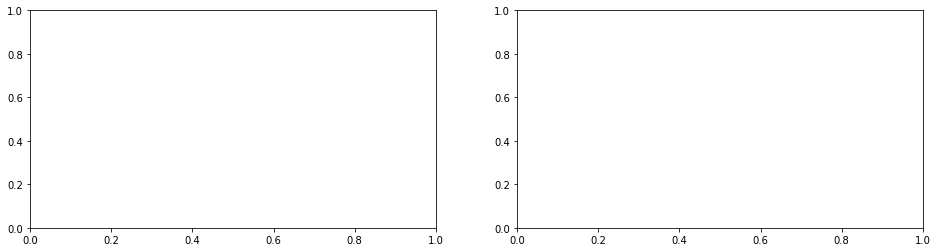

In [18]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize = (16, 4))

training_loss = model.history.history['loss']
validation_loss = model.history.history['val_loss']

training_accuracy = model.history.history['dice_coef'] #dice_coef, class_tversky, iou_score
validation_accuracy = model.history.history['val_dice_coef']

epoch_count = range(1, len(training_loss) + 1)

axs[0].plot(epoch_count, training_loss, 'r--')
axs[0].plot(epoch_count, validation_loss, 'b-')
axs[0].legend(['Training Loss', 'Validation Loss'])

axs[1].plot(epoch_count, training_accuracy, 'r--')
axs[1].plot(epoch_count, validation_accuracy, 'b-')
axs[1].legend(['Training Accuracy', 'Validation Accuracy'])

In [11]:
# Visualize prediction
import matplotlib.pyplot as plt
import tensorflow as tf
def display_sample(display_list, title = ['Input Image', 'True Mask', 'Predicted Mask']):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15, 15))

    cmaps = [None, plt.cm.binary_r]
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if i==0:
            plt.imshow(display_list[i], cmap=cmaps[0])
        else:
            plt.imshow(display_list[i], cmap=cmaps[1])
        plt.axis('off')
    plt.show()

# Testing on Test data

In [12]:
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = np.expand_dims(y_test, axis=3)

In [13]:
X_test.shape, y_test.shape

((73, 512, 512, 3), (73, 512, 512, 1, 1))

In [14]:
model.load_weights(ckp_path)
model.evaluate(X_test, y_test)

3/3 [==============================] - 6s 985ms/step - loss: -0.7001 - dice_coef: 0.9202 - iou_score: 0.8529


[-0.7001445293426514, 0.9202218055725098, 0.8528510928153992]

In [15]:
pred = model.predict(X_test, batch_size=36)
print(classification_report(y_test.flatten()>0.5, pred.flatten()>0.5, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96  13222228
           1       0.91      0.92      0.92   5914284

    accuracy                           0.95  19136512
   macro avg       0.94      0.94      0.94  19136512
weighted avg       0.95      0.95      0.95  19136512



In [16]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test.flatten()>0.5, pred.flatten()>0.5).ravel()
acc = (tn+tp)/(tn+fp+fn+tp)
dice_score = 2*tp/(2*tp+fp+fn)
prcs = tp/(tp+fp)
rc = tp/(tp+fn)
print("Accuracy: ", acc)
print("Precision: ", prcs)
print("Recall: ", rc)
print("DSC: ", dice_score)

Accuracy:  0.9481836606378424
Precision:  0.9099508795118997
Recall:  0.9237561131660231
DSC:  0.9168015293461415


In [17]:
pred = model.predict(X_test, batch_size=8)
print(classification_report(y_test.flatten()>0.5, pred.flatten()>0.5, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96  13222228
           1       0.91      0.92      0.92   5914284

    accuracy                           0.95  19136512
   macro avg       0.94      0.94      0.94  19136512
weighted avg       0.95      0.95      0.95  19136512

